# <center>TMVA Classification Using BDT</center>

In this notebook we still classify di-Higgs new data with Boosted Decision Trees meethod.

In [1]:
import ROOT
from ROOT import TMVA, TTree
import array

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

Welcome to JupyROOT 6.14/04


### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [2]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [3]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "PreSel_2tag", "Xtohh1000")

In [4]:
outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

signal_tree.Print()

******************************************************************************
*Tree    :Nominal   : Nominal                                                *
*Entries :     4343 : Total =          456559 bytes  File  Size =     259576 *
*        :          : Tree compression factor =   5.92                       *
******************************************************************************
*Br    0 :sample    : string                                                 *
*Entries :     4343 : Total  Size=      61643 bytes  File Size  =       5536 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   9.00     *
*............................................................................*
*Br    1 :EventWeight : EventWeight/F                                        *
*Entries :     4343 : Total  Size=      18059 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [5]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree,     signalWeight     )
loader.AddBackgroundTree( backg_tree, backgroundWeight )

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Nominal of type Signal with 4343 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Nominal of type Background with 995 events


There are:
- 79336 signal events
- 231046 background events

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.


In [6]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=2000:nTrain_Background=800:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## BDT

In [7]:
## Boosted Decision Trees
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
                   "!V:NTrees=3000:MinNodeSize=5%:MaxDepth=1:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                   "BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )

<ROOT.TMVA::MethodBDT object ("BDT") at 0x710d8c0>

Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 2000
                         : Signal     -- testing events             : 2343
                         : Signal     -- training and testing events: 4343
                         : Background -- training events            : 800
                         : Background -- testing events             : 195
                         : Background -- training and testing events: 995
                         : 
DataSetInfo              : Correlation matrix (Signal):
                         : ------------------------------------------------------------------------

## Train Methods

In [8]:
factory.TrainAllMethods()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_FJpt' <---> Output : variable 'm_FJpt'
                         : Input : variable 'm_FJm' <---> Output : variable 'm_FJm'
                         : Input : variable 'm_DTpt' <---> Output : variable 'm_DTpt'
                         : Input : variable 'm_DTm' <---> Output : variable 'm_DTm'
                         : Input : variable 'm_dPhiFTwDT' <---> Output : variable 'm_dPhiFTwDT'
                         : Input : variable 'm_dRFJwDT' <---> Output : variable 'm_dRFJwDT'
                         : Input : variable 'm_dPhiDTwMET' <---> Output : variable 'm_dPhiDTwMET'
                         : Input : variable 'm_MET' <---> Output : variable 'm_MET'
                         : Input : variable 'm_hhm' <--->

## Test  all methods

Here we test all methods using the test data set

In [9]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (2538 events)
                         : Elapsed time for evaluation of 2538 events: 0.361 sec       


## Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [10]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT            :     Variable            Mean            RMS    [        Min            Max ]
                         : -------------------------------------------------------------------------------
                         :       m_FJpt:        480.35        97.375   [        251.56        1208.5 ]
                         :        m_FJm:    1.2488e+05        39413.   [        4878.0    4.3556e+05 ]
                         :       m_DTpt:        452.88        82.273   [        316.33        963.39 ]
                         :        m_DTm:    1.5746e+05        33247.   [        77090.    3.5290e+05 ]
                         :  m_dPhiFTwDT:        2.8569       0.39905   [      0.068093        3.1414 ]
         

## Plot ROC Curve
We enable JavaScript visualisation for the plots

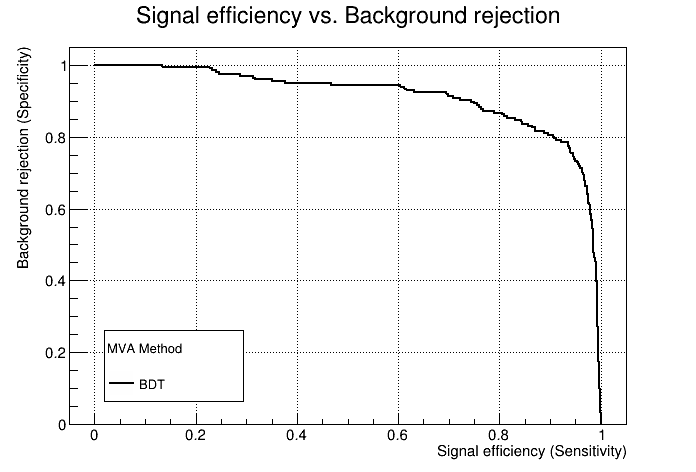

In [11]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## Prediction

### Declare Reader

In [92]:
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize();

reader = TMVA.Reader( "!Color:!Silent" )

In [93]:
methodNames = ["BDT"]

dataFile = ROOT.TFile("PreSel_2tag_Xtohh1000_d.root")
bkgFile = ROOT.TFile("PreSel_2tag_Xtohh1000_b.root")
sigFile = ROOT.TFile("PreSel_2tag_Xtohh1000_s.root")

dataTree = dataFile.Nominal
bkgTree = bkgFile.Nominal
sigTree = sigFile.Nominal

Warning in <TFile::Init>: file PreSel_2tag_Xtohh1000_d.root probably not closed, trying to recover
Info in <TFile::Recover>: PreSel_2tag_Xtohh1000_d.root, recovered key TTree:Nominal at address 252
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file PreSel_2tag_Xtohh1000_b.root probably not closed, trying to recover
Info in <TFile::Recover>: PreSel_2tag_Xtohh1000_b.root, recovered key TTree:Nominal at address 252
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file PreSel_2tag_Xtohh1000_s.root probably not closed, trying to recover
Info in <TFile::Recover>: PreSel_2tag_Xtohh1000_s.root, recovered key TTree:Nominal at address 22741
Warning in <TFile::Init>: successfully recovered 1 keys


### Add Variable

We add variables to the reader exactly in the same way we did for the **DataLoader** during the training

We need to specify the address of the variable in order to pass it to TMVA when we iterate on the TTree

In [94]:
variables = []
i = 0

for branch in dataTree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    aux = array('f',[0])
    variables.append(aux)
    reader.AddVariable(branch.GetName(),variables[i])
    i = i+1


### Setup Classifiers

We set up the classifiers by reading the input weights from the appropriate files

The file is stored for example as 

####  *dataset/weights/TMVAClassification_BDT.weights.xml

In [95]:
for methodName in methodNames: 
    weightfile = "dataset/weights/TMVA_Higgs_Classification_" + methodName + ".weights.xml"
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile );

                         : Booking "BDT" of type "BDT" from dataset/weights/TMVA_Higgs_Classification_BDT.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Higgs_Classification_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT" of type: "BDT"


### Evaluation of the classifier on the given input events

We iterate on the input event in the given TTree. We provide as input first the background tree 
We return the output results for the various methods in big numpy array [ number of methods x number of events]
We also fill an histogram for each method.
Note that is important to fill the arrays with the tree entries in order to pass the values to the TMVA::Reader

In [103]:
import numpy as np

def v_out(tree):
    h = {}
    hname = "hdata_BDT"
    h['BDT'] = (ROOT.TH1D(hname,htitle,60,-1,1) )
    
    nevt = tree.GetEntries()

    vout = np.arange(nevt * len(methodNames), dtype='float').reshape( len(methodNames), nevt)

    for ievt, entry in enumerate(tree):
        i = 0    
        for branch in tree.GetListOfBranches():
            name = branch.GetName()
            if name in not_cons:
                continue
            variables[i][0] = getattr(entry,name)
            i += 1

        for j, methodName in enumerate(methodNames): 
            vout[j,ievt] = reader.EvaluateMVA(methodName)
            h[methodName].Fill(vout[j,ievt])
    
    return h, vout

In [104]:
hd, d_vout = v_out(dataTree)
hs, s_vout = v_out(sigTree)
hb, b_vout = v_out(bkgTree)

Warning in <TFile::Append>: Replacing existing TH1: hdata_BDT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hdata_BDT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hdata_BDT (Potential memory leak).


In [105]:
print(s_vout)

[[0.09332911 0.12914337 0.15641321 ... 0.11140298 0.01943621 0.07577489]]


### Plot Histogram of output variables

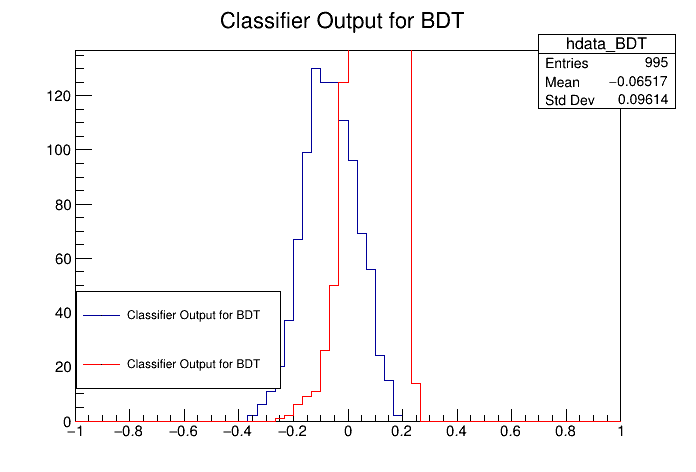

In [106]:
c1 = ROOT.TCanvas()
c1.DivideSquare( len(hb))
ipad = 0
for name in methodNames: 
    ipad += 1
    pad = c1.cd(ipad)
    h1 = hb[name]
    h1.Draw()
    h2 = hs[name]
    h2.SetLineColor(ROOT.kRed)
    h2.Draw('Same')
    pad.BuildLegend()
    
c1.Draw()

In [89]:
dataFile.Close()
sigFile.Close()
bkgFile.Close()